# Random Forest 

Import libraries. 

In [2]:
# Import necessary libraries
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, confusion_matrix
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix 
from collections import Counter

# Import data 

In [3]:
# Load the data into pandas dataframes
X_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_train_resampled.csv')
y_train = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_train_resampled.csv')
X_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/X_test.csv')
y_test = pd.read_csv('/Users/dionnespaltman/Desktop/V6/data_04-06-2024/y_test.csv')

X_train = X_train.drop(columns='Unnamed: 0', axis=1)
y_train = y_train.drop(columns='Unnamed: 0', axis=1)
X_test = X_test.drop(columns='Unnamed: 0', axis=1)
y_test = y_test.drop(columns='Unnamed: 0', axis=1)

# Convert the DataFrame to a NumPy array
# y_test = y_test.to_numpy()

# Display the first few rows of each dataframe to verify the loading
print("X_train_res:")
display(X_train.head())

print("\ny_train_res:")
display(y_train.head())

print("\nX_test:")
display(X_test.head())

print("\ny_test:")
# print(y_test)
display(y_test.head())

# Convert the DataFrame to a 1-dimensional NumPy array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


X_train_res:


,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,12.0,13.0,-0.114682,-0.412734,-0.175865,0.415941,-0.687555,-0.400360,0.970556,0.364929,...,-0.588472,0.201653,-1.080948,-1.005558,-1.057202,-1.532650,-1.499128,-1.273469,-2.129886,-2.037173
1,17.0,16.0,-0.038570,-0.768864,-0.561401,0.504332,-0.809168,-0.758472,0.333551,-0.368145,...,0.289276,0.440930,0.189637,0.225341,1.063062,0.406128,0.477464,0.619122,-0.068091,0.354797
2,16.0,12.0,-0.436004,0.206480,0.369342,0.158133,-0.021607,0.244861,-0.836108,-0.490845,...,0.522235,0.440930,0.181549,0.373204,-0.399350,0.048667,0.213801,-0.150745,0.132589,0.169110
3,8.0,8.0,0.558569,0.560424,0.637285,0.504332,0.287352,0.558101,0.411212,0.165073,...,-0.045264,0.440930,-0.462771,-0.331676,-0.090762,-0.747721,-0.481159,0.330422,-0.600511,-0.671622
4,9.0,8.0,0.039454,0.762845,0.780378,0.364379,0.528676,0.748981,-0.131359,0.091414,...,-0.535630,0.440930,-0.856850,-0.858808,0.063929,0.829485,0.764250,0.619122,0.779664,0.855063



y_train_res:


,VVR_group
0,1
1,1
2,1
3,0
4,0



X_test:


,Sum_1,Sum_2,AU01_r__sum_values,AU01_r__variance,AU01_r__standard_deviation,AU01_r__maximum,AU01_r__mean,AU01_r__root_mean_square,AU02_r__sum_values,AU02_r__variance,...,AU26_r__standard_deviation,AU26_r__maximum,AU26_r__mean,AU26_r__root_mean_square,AU45_r__sum_values,AU45_r__variance,AU45_r__standard_deviation,AU45_r__maximum,AU45_r__mean,AU45_r__root_mean_square
0,9.0,11.0,-1.954248,-0.951158,-0.794258,-2.000083,0.255940,-0.532746,-1.756362,-0.587427,...,-0.166497,-0.729816,2.825468,1.673580,-2.233545,0.289550,0.393906,-0.511621,1.873165,0.899641
1,11.0,10.0,-0.531321,-0.178666,0.044588,0.504332,-0.398439,-0.134585,-0.306588,-0.141707,...,-0.363370,-0.080351,-0.509222,-0.565219,-0.579429,-0.022861,0.158174,0.466753,-0.568289,-0.075143
2,11.0,10.0,-0.293895,0.814623,0.815957,0.504332,0.187131,0.677928,0.120579,1.064580,...,0.567536,0.440930,0.271424,0.449194,-0.116745,0.791976,0.739793,0.129936,0.675229,0.802541
3,8.0,8.0,-0.462186,-0.190678,0.033761,0.504332,-0.500519,-0.171970,0.077514,0.198167,...,0.187859,0.346928,-0.008672,0.055083,-0.336010,-0.518784,-0.261437,-0.190843,-0.460154,-0.433136
4,8.0,8.0,1.797969,2.225527,1.667268,0.504332,1.289613,1.707848,1.420513,0.971025,...,-0.077072,0.440930,-0.477280,-0.360369,0.855433,0.216467,0.340371,0.202111,0.358639,0.349728



y_test:


,VVR_group
0,0
1,0
2,0
3,0
4,0


# Model with inner and outer split

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html 

In [3]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.svm import SVR


# Declare the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
# Create the pipeline with RFE and the model
# rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
rfe = RFE(estimator=DecisionTreeClassifier())
# rfe = RFE(SVR(kernel="linear"))
# rfe = RFE(SVC(kernel="linear"))
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

param_grid = {
    'm__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'm__class_weight': [{0: 0.6428571428571429, 1: 2.25}, None],  # Class weights
    'm__max_depth': [None, 10, 20],  # Maximum depth of the tree
    's__n_features_to_select': [5, 10, 20, 40, 60, 80]  # Number of features to select with RFE
}

# Inner cross-validation for parameter search
model = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2
)

# Outer cross-validation to compute the testing score
test_score = cross_val_score(model, X_train_res, y_train_res, cv=outer_cv, n_jobs=2)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score.mean():.3f} ± {test_score.std():.3f}"
)

# Print shape
print(X_train_res.shape)
print(y_train_res.shape)

# Fit model to training data to get best parameters
model.fit(X_train_res, y_train_res)

# Print best parameters
print(model.best_params_)

# Print the features that were selected with RFE

# Evaluate on the test set
best_model = model.best_estimator_
y_pred = best_model.predict(X_test)

# Print shape
print(y_test.shape)
print(y_pred.shape)

# Print classification report 
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Calculate and print the AUC-PR
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_proba)
auc_pr = auc(recall, precision)
print(f"AUC-PR: {auc_pr:.3f}")

# # For class 0
# precision_0, recall_0, _ = precision_recall_curve(y_test, y_proba[:, 0], pos_label=0)
# auc_pr_0 = auc(recall_0, precision_0)
# print(f"AUC-PR for class 0: {auc_pr_0:.3f}")

# # For class 1
# precision_1, recall_1, _ = precision_recall_curve(y_test, y_proba[:, 1], pos_label=1)
# auc_pr_1 = auc(recall_1, precision_1)
# print(f"AUC-PR for class 1: {auc_pr_1:.3f}")

# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
# print(metrics.auc(fpr, tpr))

The mean score using nested cross-validation is: 0.884 ± 0.034
(112, 104)
(112,)
{'m__class_weight': None, 'm__max_depth': None, 'm__n_estimators': 200, 's__n_features_to_select': 60}
(32,)
(32,)

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        25
           1       0.50      0.43      0.46         7

    accuracy                           0.78        32
   macro avg       0.67      0.65      0.66        32
weighted avg       0.77      0.78      0.77        32

[[22  3]
 [ 4  3]]
AUC-PR: 0.378


# Optimized code 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import seaborn as sns

def build_pipeline():
    """Builds the machine learning pipeline with RFE and RandomForestClassifier."""
    rfe = RFE(estimator=DecisionTreeClassifier(random_state=0))  # Recursive feature elimination with a decision tree
    model = RandomForestClassifier(random_state=0)  # Random forest classifier
    return Pipeline(steps=[('feature_selection', rfe), ('classifier', model)])  # Pipeline combining feature selection and classification

def get_param_grid():
    """Returns the hyperparameter grid for GridSearchCV."""
    return {
        'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest
        'classifier__class_weight': [{0: 0.75, 1: 1.48}, None],  # Class weights
        'classifier__max_depth': [None, 10, 20],  # Maximum depth of the tree
        'feature_selection__n_features_to_select': [5, 10, 20, 40, 80]  # Number of features to select with RFE
    }

def perform_nested_cv(X, y, random_state=0):
    """Performs nested cross-validation and returns the test scores."""
    # Define the inner and outer cross-validation strategies
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
    
    pipeline = build_pipeline()  # Build the pipeline
    param_grid = get_param_grid()  # Get the hyperparameter grid
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv, n_jobs=2)
    # Perform nested cross-validation
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, n_jobs=2, return_estimator=True, return_train_score=True)
    
    test_scores = cv_results['test_score']  # Extract test scores
    test_score_mean = test_scores.mean()  # Calculate mean test score
    test_score_std = test_scores.std()  # Calculate standard deviation of test scores
    
    print(f"Test scores for each fold: {test_scores}")
    
    print(f"The mean score using nested cross-validation is: {test_score_mean:.3f} ± {test_score_std:.3f}")
    
    return cv_results

def plot_curves(y_test, y_proba, y_pred):
    """Plots PR and ROC curves."""
    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

def evaluate_model(cv_results, X_train, y_train, X_test, y_test):
    """Evaluates the model on the test set."""
    best_estimator_per_fold = [result.best_estimator_ for result in cv_results['estimator']]  # Get best estimator for each fold
    
    # Evaluate the best model on the test set
    best_model = best_estimator_per_fold[np.argmax(cv_results['test_score'])]  # Select the best model based on test scores
    
    print("\nEvaluating best model on test set")
    y_test_pred = best_model.predict(X_test)  # Predict on the test set
    
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_test_pred))  # Print classification report
    print(confusion_matrix(y_test, y_test_pred))  # Print confusion matrix
    
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Get prediction probabilities
    plot_curves(y_test, y_test_proba, y_test_pred)  # Plot PR and ROC curves
    
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    auc_pr = auc(recall, precision)
    print(f"Test AUC-PR: {auc_pr:.3f}")  # Print AUC-PR score

    return y_test_pred


# Assuming X_train_12, y_train_12, X_test_12, and y_test are predefined
random_seed = 42

cv_results = perform_nested_cv(X_train, y_train, random_state=random_seed)  # Perform nested cross-validation
y_test_pred = evaluate_model(cv_results, X_train, y_train, X_test, y_test)  # Evaluate the model on the test set


# Confusion matrix 

/var/folders/_4/nzq6mygj7j71_l3z_c9kc7wr0000gn/T/ipykernel_2179/260311700.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


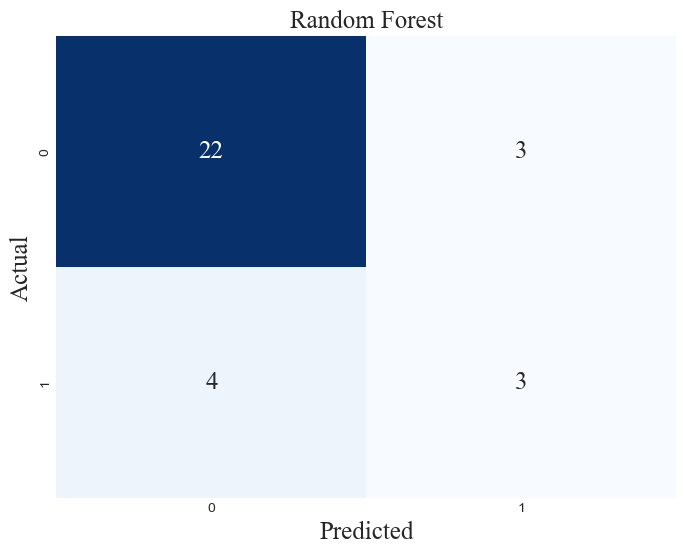

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

font = 'Times New Roman'
size = 18

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Set the style to a modern style
plt.style.use('seaborn-darkgrid')

# Create a custom diverging color map
colors = sns.color_palette("Blues", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=colors, cbar=False,
            annot_kws={'fontname': font, 'fontsize': size})  # Set font and size for numbers
plt.title('Random Forest', fontname=font, fontsize=size)
plt.xlabel('Predicted', fontname=font, fontsize=size)
plt.ylabel('Actual', fontname=font, fontsize=size)

plt.show()